In [204]:
# Import required libraries

import numpy as np
import pandas as pd

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa import tsatools
# from dmba import regressionSummary

import pickle


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
pd.options.display.max_columns = 20 
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True) # Displays only upto 4 decimals
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress specific FutureWarnings

In [263]:
# Load the Excel files
data = pd.read_csv("./final_sugar_price_forecasting_data.csv")
data

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
0,67.67,97131.0,321130.0,1/1/2018,39.20,-,2.77
1,60.54,114127.0,0.0,2/1/2018,39.10,-0.00255102,-0.17
2,51.64,134766.0,59110.0,3/1/2018,38.94,-0.003978403,-1.61
3,28.48,159955.0,0.0,4/1/2018,37.70,-0.031859249,-4.05
4,9.18,218721.0,135470.0,5/1/2018,35.36,-0.062202928,-8.21
...,...,...,...,...,...,...,...
78,NaN,NaN,NaN,7/1/2024,42.70,-0.009028112,5.22
79,NaN,NaN,NaN,8/1/2024,43.27,0.013378313,4.70
80,NaN,NaN,NaN,9/1/2024,42.68,-0.013653484,3.46
81,NaN,NaN,NaN,10/1/2024,42.88,0.004886092,NaN


### Random Forest

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta

In [310]:
# Step 2: Prepare the Data

data_rf = data.copy()

# Convert 'date' column to datetime format
data_rf['Date'] = pd.to_datetime(data_rf['Date'])

# Set 'Date' as the index
# data_rf.set_index('Date', inplace=True)

# Sort the data by date (important for time series)
data_rf = data_rf.sort_index()

In [311]:
# Step 3: Feature Engineering

# Extract time-based features from the date
data_rf['year'] = data_rf['Date'].dt.year
data_rf['month'] = data_rf['Date'].dt.month

# Create lag features (previous prices)
num_lags = 12  # Number of lag features (e.g., for the past 12 months)
for lag in range(1, num_lags + 1):
    data_rf[f"lag_{lag}"] = data_rf['Sugar Price'].shift(lag)

In [312]:
# X = data_rf[['year', 'month', 'Monthly Production (lakh tonnes)', 'CPI', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)'] + [f'lag_{i}' for i in range(1, num_lags + 1)]] 
# X = data_rf[['year', 'month', 'Monthly Production (lakh tonnes)', 'CPI', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)']]
X = data_rf[['year', 'month']]
y = data_rf['Sugar Price']

In [313]:
# Step 4: Split the Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [314]:
param_grid = {
    'n_estimators': [65],   # Number of trees in the forest
    'max_depth': [5],         # Maximum depth of the trees
    'min_samples_split': [5],  # Minimum samples required to split a node
    # 'min_samples_leaf': [1, 2, 4]     # Minimum samples required at each leaf node
}


In [315]:
# Step 5: Train the Random Forest Model
rf_model = RandomForestRegressor(
    # n_estimators=100,  # Number of trees
    random_state=42,
    # max_depth=10,  # Set tree depth (tune for your data)
)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Step 5: Train the Best Model
best_rf_model.fit(X_train, y_train)

# Step 6: Predict and Evaluate on Test Data
y_pred = best_rf_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [316]:
best_params

{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 65}

In [317]:
# Evaluate long-term performance
print('LONG-TERM PERFORMANCE')

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# Evaluate short-term performance
print('SHORT-TERM PERFORMANCE')
mae = mean_absolute_error(y_test[:6], y_pred[:6])
rmse = np.sqrt(mean_squared_error(y_test[:6], y_pred[:6]))
mape = mean_absolute_percentage_error(y_test[:6], y_pred[:6])
r2 = r2_score(y_test[:6], y_pred[:6])

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

LONG-TERM PERFORMANCE
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.75
Root Mean Squared Error (RMSE): 0.96
Mean Absolute Percentage Error (MAPE): 1.75
R-squared (R2 Score): -2.4914
SHORT-TERM PERFORMANCE
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.43
Root Mean Squared Error (RMSE): 0.52
Mean Absolute Percentage Error (MAPE): 1.00
R-squared (R2 Score): -0.4603


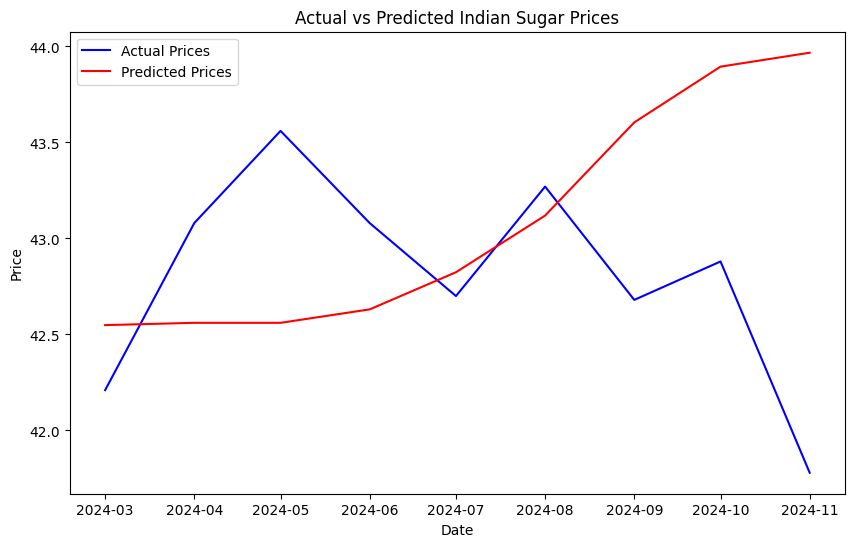

In [318]:
# Step 7: Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(data_rf['Date'][-len(y_test):], y_test, label="Actual Prices", color="blue")
plt.plot(data_rf['Date'][-len(y_test):], y_pred, label="Predicted Prices", color="red")
# plt.plot(data_rf['Date'][-len(y_train):], y_train, label='Training Data', color='blue')
# plt.plot(data_rf['Date'][-len(y_test):], y_test, label='Actual Prices (Test)', color='green')
# plt.plot(data_rf['Date'][-len(y_test):], y_pred, label='Forecasted Prices', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Actual vs Predicted Indian Sugar Prices")
plt.legend()
plt.show()

In [303]:
pickle.dump(best_rf_model, open('./short-term-forecasting-model.pkl', 'wb'))
pickle.dump(best_rf_model, open('./long-term-forecasting-model.pkl', 'wb'))

### Winter Holt

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [217]:
# Filter the dataset to include only rows where all five variables are present
model3_data = data.dropna(subset=['Sugar Price'])

model3_data = model3_data.drop(['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'Price Change', 'CPI'], axis=1)

model3_data['Date'] = pd.to_datetime(model3_data['Date'])
model3_data = model3_data.set_index('Date')  # Set 'date' as the index for time series analysis
# model3_data = model3_data.asfreq('M')

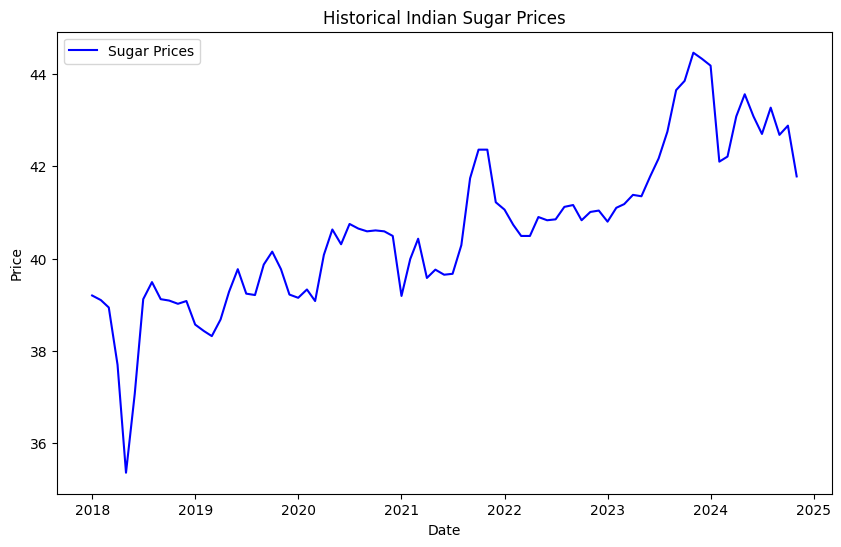

In [218]:
# Step 2: Plot the Data
plt.figure(figsize=(10, 6))
plt.plot(model3_data.index, model3_data['Sugar Price'], label='Sugar Prices', color='blue')
plt.title('Historical Indian Sugar Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [219]:
# Step 3: Split Data into Train and Test Sets
train_size = int(len(model3_data) * 0.8)  # Use 80% for training, 20% for testing
train = model3_data.iloc[:train_size]
test = model3_data.iloc[train_size:]

In [220]:
test

,Sugar Price
Date,
2023-07-01,42.17
2023-08-01,42.75
2023-09-01,43.65
2023-10-01,43.85
2023-11-01,44.46
2023-12-01,44.33
2024-01-01,44.18
2024-02-01,42.10
2024-03-01,42.21


In [221]:
# Step 4: Train the Holt-Winters Model
# Additive trend and multiplicative seasonality for monthly data
model = ExponentialSmoothing(
    train,
    trend='add',            # Trend: Additive
    seasonal='add',         # Seasonality: Multiplicative
    seasonal_periods=12,     # Periodicity: 12 months for yearly seasonality
    damped_trend=False,
    # use_boxcox=True
)

d:\ISB\Term 4\Foundation Project\FP-Codebase\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [222]:
# Fit the model
hw_model = model.fit(optimized=True)

# Step 5: Forecast on Test Data
test_forecast = hw_model.forecast(len(test))

In [239]:
test, test_forecast

(            Sugar Price
 Date                   
 2023-07-01        42.17
 2023-08-01        42.75
 2023-09-01        43.65
 2023-10-01        43.85
 2023-11-01        44.46
 2023-12-01        44.33
 2024-01-01        44.18
 2024-02-01        42.10
 2024-03-01        42.21
 2024-04-01        43.08
 2024-05-01        43.56
 2024-06-01        43.08
 2024-07-01        42.70
 2024-08-01        43.27
 2024-09-01        42.68
 2024-10-01        42.88
 2024-11-01        41.78,
 2023-07-01    42.180006
 2023-08-01    42.405988
 2023-09-01    42.749973
 2023-10-01    42.861939
 2023-11-01    42.803947
 2023-12-01    42.464019
 2024-01-01    42.008098
 2024-02-01    42.126429
 2024-03-01    42.086428
 2024-04-01    41.998066
 2024-05-01    41.893047
 2024-06-01    42.248017
 2024-07-01    42.648023
 2024-08-01    42.874005
 2024-09-01    43.217990
 2024-10-01    43.329956
 2024-11-01    43.271964
 Freq: MS, dtype: float64)

In [240]:
# Step 6: Evaluate the Model

print('LONG-TERM PERFORMANCE')
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))
mape = mean_absolute_percentage_error(test, test_forecast)
r2 = r2_score(test, test_forecast)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# Evaluate short-term performance
print('SHORT-TERM PERFORMANCE')
mae = mean_absolute_error(test[:6], test_forecast[:6])
rmse = np.sqrt(mean_squared_error(test[:6], test_forecast[:6]))
mape = mean_absolute_percentage_error(test[:6], test_forecast[:6])
r2 = r2_score(test[:6], test_forecast[:6])
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

LONG-TERM PERFORMANCE
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.86
Root Mean Squared Error (RMSE): 1.09
Mean Absolute Percentage Error (MAPE): nan
R-squared (R2 Score): -0.9334
SHORT-TERM PERFORMANCE
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.96
Root Mean Squared Error (RMSE): 1.16
Mean Absolute Percentage Error (MAPE): nan
R-squared (R2 Score): -0.9927


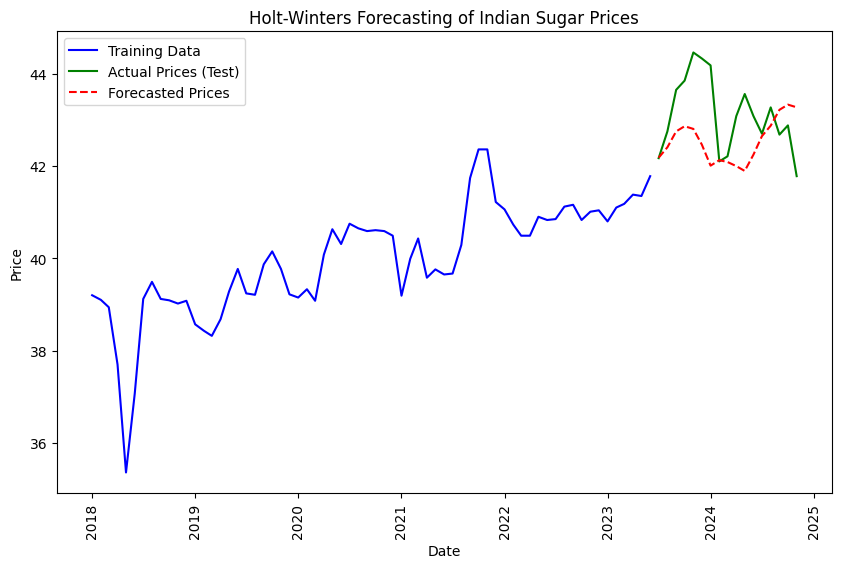

In [224]:
# Step 7: Plot Actual vs Forecasted Prices
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Sugar Price'], label='Training Data', color='blue')
plt.plot(test.index, test['Sugar Price'], label='Actual Prices (Test)', color='green')
plt.plot(test.index, test_forecast, label='Forecasted Prices', color='red', linestyle='--')
plt.title('Holt-Winters Forecasting of Indian Sugar Prices')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.legend()
plt.show()


In [225]:
pickle.dump(hw_model, open('./short-term-forecasting-model.pkl', 'wb'))
pickle.dump(best_rf_model, open('./long-term-forecasting-model', 'wb'))